In [1]:
from utils import *
from collections import Counter
import os

In [3]:
iemocap = pd.read_csv("6emo/test/iemocap_6emo.csv")
msp_podcast = pd.read_csv("6emo/test/msp_podcast_6emo.csv")
# msp_improv = pd.read_csv("original/msp-improv.csv")
crema_d = pd.read_csv("6emo/test/crema_d_6emo.csv")

In [2]:
combine_corpus = pd.read_csv("6emo/train&val/train&val_6emo_original.csv")

In [3]:
podcast_emotion = ['angry','sad','disgust','contempt', 'fear', 'neutral','surprise','happy']
# improv_emotion = ["angry","sad","neutral","happy"]
iemocap_emotion = ["frustrated","angry","sad","disgust","fear","neutral","surprise","happy"] # Happy & Excited combine together
crema_emotion = ["angry","sad","disgust","fear","neutral","happy"]

In [4]:
# Combine happy and excited emotion
iemocap['happy'] = iemocap['happy'] + iemocap['excited']
iemocap = iemocap.drop(columns='excited')

### Get the dominant emotion and the drop rate

In [5]:
def get_dominant_emotion(corpus, all_emotions):
    # Create a new column for dominant emotion
    corpus['dominant_emotion'] = None
    
    # Iterate through each row of the dataframe
    for index, row in corpus.iterrows():
        # Get emotion scores for all emotions in the dataset
        emotion_scores = [row[emotion] for emotion in all_emotions if emotion in row]
        # Find the maximum score
        max_score = max(emotion_scores)
        
        # Find all emotions with the maximum score
        max_emotions = [emotion for emotion in all_emotions if emotion in row and row[emotion] == max_score]
        # If there's only one emotion with max score, it's the dominant one
        if len(max_emotions) == 1:
            corpus.at[index,'dominant_emotion'] = max_emotions[0]
        else:
            # If there's a tie, mark as 'ambiguous' or handle as needed
            corpus.at[index,'dominant_emotion'] = 'ambiguous'

    # Remove rows where dominant_emotion is NaN
    corpus = corpus.dropna(subset=['dominant_emotion'])
    return corpus

In [6]:
iemocap = get_dominant_emotion(iemocap,iemocap_emotion)
drop_rate_calculator(iemocap)

drop rate of Train set : 12.83%
drop rate of Development set : 14.70%
drop rate of Test set : 11.60%
Overall drop rate : 12.98%


In [7]:
msp_podcast = get_dominant_emotion(msp_podcast,podcast_emotion)
drop_rate_calculator(msp_podcast)

drop rate of Train set : 20.05%
drop rate of Development set : 20.17%
drop rate of Test set : 19.35%
Overall drop rate : 19.85%


In [8]:
# msp_improv = get_dominant_emotion(msp_improv,improv_emotion)
# drop_rate_calculator(msp_improv)

drop rate of Train set : 5.64%
drop rate of Development set : 5.95%
drop rate of Test set : 5.05%
Overall drop rate : 5.63%


In [8]:
crema_d = get_dominant_emotion(crema_d,crema_emotion)
drop_rate_calculator(crema_d)

drop rate of Train set : 8.07%
drop rate of Development set : 9.25%
drop rate of Test set : 9.30%
Overall drop rate : 8.55%


### Normalize the Activation & Valence
Crema-D no need, since it doesn't have dimensional emotion data 

In [9]:
print('='*10 + ' IEMOCAP '.center(12) + '='*10)
iemocap = Normalize_dimensional_emotion(iemocap)
print('='*10 + ' MSP-Podcast '.center(12) + '='*10)
msp_podcast = Normalize_dimensional_emotion(msp_podcast)
# print('='*10 + ' MSP-Improv '.center(12) + '='*10)
# msp_improv = Normalize_dimensional_emotion(msp_improv)

==========  IEMOCAP   ==========
Activation: Min 1.0 Max5.0
Valence: Min 1.0 Max5.0
========== MSP-Podcast ==========
Activation: Min 1.0 Max7.0
Valence: Min 1.0 Max7.0


### Remove the ambiguous data

In [10]:
def ambiguous_segregation(corpus,file_name):
    ambiguous_data = corpus[corpus['dominant_emotion'] == 'ambiguous']
    ambiguous_data.to_csv(os.path.join('ambiguous',file_name))
    new_data = corpus[corpus['dominant_emotion'] != 'ambiguous']
    return new_data

In [11]:
iemocap = ambiguous_segregation(iemocap,'iemocap_ambiguous.csv')
msp_podcast = ambiguous_segregation(msp_podcast,'msp_podcast_ambiguous.csv')
# msp_improv = ambiguous_segregation(msp_improv,'msp_improv_ambiguous.csv')
crema_d = ambiguous_segregation(crema_d,'crema_d_ambiguous.csv')

### Get the total Train set

In [12]:
def train_segregation(corpus,file_name,only_test=False,corpus_name=None):
    columns_to_keep = ['FileName', 'dominant_emotion', 'EmoAct', 'EmoVal', 'Gender','Split_Set']
    selected_data = corpus[columns_to_keep].copy()
    selected_data['Corpus']= corpus_name
    test_data = selected_data[selected_data['Split_Set'] == 'Test']
    test_data.to_csv(os.path.join('test',file_name))
    if only_test == True:
        return
    new_train_data = selected_data[selected_data['Split_Set'] == 'Train']
    new_valid_data = selected_data[selected_data['Split_Set'] == 'Development']
    return new_train_data, new_valid_data

In [13]:
iemocap_train, iemocap_val = train_segregation(iemocap,'iemocap_test.csv',False,'IEMOCAP')
msp_podcast_train, msp_podcast_val = train_segregation(msp_podcast,'msp_podcast_test.csv',False,'MSP-PODCAST')
# msp_improv_train, msp_improv_val = train_segregation(msp_improv,'msp_improv_test.csv',False,'MSP-IMPROV')
# crema_d = train_segregation(crema_d,'crema_d_test.csv',only_test=True) #Only saved test_data

In [14]:
# Combine all dataframes into one
combined_train = pd.concat([iemocap_train, msp_podcast_train], ignore_index=True)
combined_val = pd.concat([iemocap_val, msp_podcast_val], ignore_index=True)

# Display the first few rows of the combined dataframe
combined_train.head()
combined_val.head()

,FileName,dominant_emotion,EmoAct,EmoVal,Gender,Split_Set,Corpus
0,Ses05M_impro03_M011.wav,happy,0.666667,0.833333,Male,Development,IEMOCAP
1,Ses05M_script01_1b_M011.wav,happy,0.375000,0.375000,Male,Development,IEMOCAP
2,Ses05F_script02_1_M010.wav,happy,0.625000,0.625000,Male,Development,IEMOCAP
3,Ses05M_script01_3_M037.wav,frustrated,0.750000,0.250000,Male,Development,IEMOCAP
4,Ses05F_impro03_M029.wav,happy,0.625000,0.625000,Male,Development,IEMOCAP


In [3]:
combined_train = combine_corpus[combine_corpus['Split_Set'] == 'Train']
combined_val = combine_corpus[combine_corpus['Split_Set'] == 'Development']
newemotions = ['neutral', 'happy', 'sad', 'angry', 'contempt', 'surprise']

In [4]:
len(combined_val),len(combined_train)

(16504, 68620)

In [17]:
# Filter combined_train and combined_val to include only the specified emotions
newemotions = ['neutral', 'happy', 'sad', 'angry', 'surprise', 'contempt']
filtered_train = combined_train[combined_train['dominant_emotion'].isin(newemotions)]
filtered_val = combined_val[combined_val['dominant_emotion'].isin(newemotions)]

In [20]:
final_train_val = pd.concat([combined_train, combined_val], ignore_index=True)
final_train_val.to_csv(f'train&val_original.csv')

In [5]:
Counter(combined_train['Gender'])

Counter({'Male': 30841, 'Female': 25396, 'Unknown': 12383})

In [31]:
total_emotion = ['frustrated','neutral','happy','angry','surprise','sad','fear','disgust','contempt']

In [11]:
shared_emotion = set()
not_shared_emotion = set()
for emo in iemocap_emotion:
    if emo in improv_emotion:
        shared_emotion.add(emo) 
    elif emo in podcast_emotion:
        shared_emotion.add(emo) 
    else:
        not_shared_emotion.add(emo)

print(shared_emotion)
print(not_shared_emotion)

"""
MSPPODCAST
{'neutral', 'fear', 'sad', 'disgust', 'surprise', 'happy', 'angry'}
{'contempt'}

IEMOCAP
{'neutral', 'fear', 'sad', 'disgust', 'surprise', 'happy', 'angry'}
{'frustrated', 'excited'}
"""
    

{'neutral', 'fear', 'sad', 'disgust', 'surprise', 'happy', 'angry'}
{'frustrated', 'excited'}


"\nMSPPODCAST\n{'neutral', 'fear', 'sad', 'disgust', 'surprise', 'happy', 'angry'}\n{'contempt'}\n\nIEMOCAP\n"

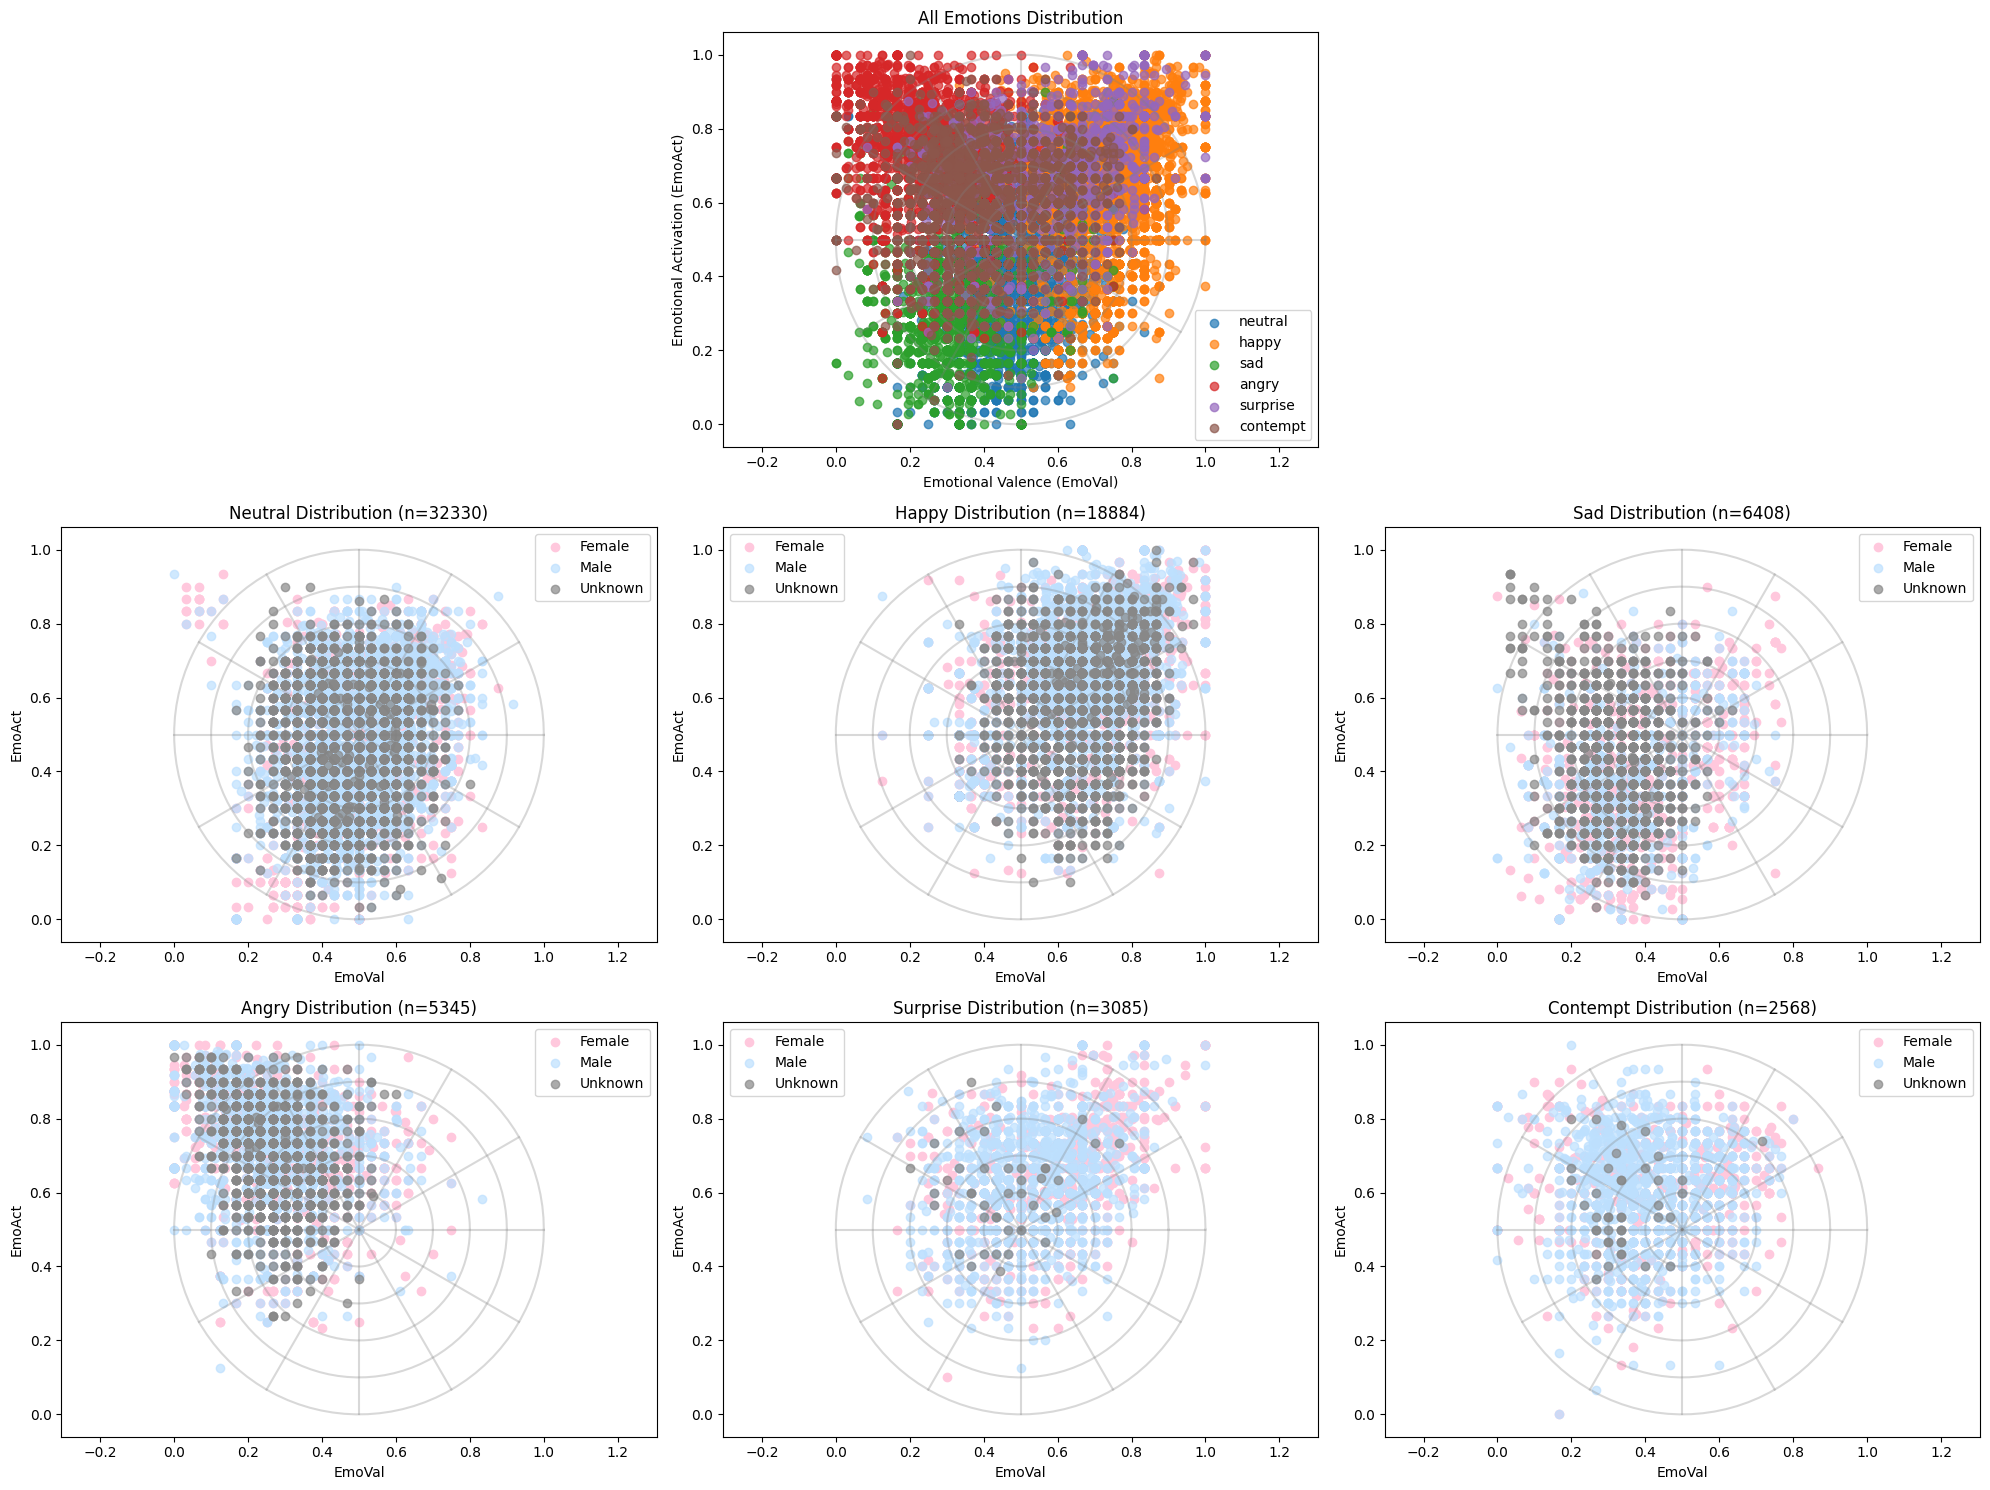

In [9]:
get_full_plot(newemotions,combined_train)

### Run DBSCAN

In [ ]:
for emo in total_emotion:
    emo_subset = combined_train[combined_train['dominant_emotion'] == emo]
    unknown_count = len(emo_subset[emo_subset['Gender'] == 'Unknown'])
    print(f'Unknown portion in {emo}: {unknown_count / len(emo_subset) * 100:.1f}%')

In [8]:
gender_groups = ['Female','Male','Unknown']
# Create a new dataframe with selected columns from each corpus
columns_to_keep = ['FileName', 'dominant_emotion', 'EmoAct', 'EmoVal', 'Gender','Split_Set','Corpus']
eps = 0.045

# Initialize an empty dataframe to store our new training set
new_train_set = pd.DataFrame(columns=columns_to_keep)

for emo in newemotions:
    emo_df = combined_train[combined_train['dominant_emotion'] == emo]
    for gender in gender_groups:
        gender_df = emo_df[emo_df['Gender'] == gender]
        if len(gender_df) > 0:
            cluster_set, X ,cluster = apply_dbscan_clustering(gender_df, emo, eps=eps,min_samples=5)
            
            if cluster.max() == -1:  # If there are valid clusters (not just noise)
                cluster_samples = cluster_set[columns_to_keep].copy()
                new_train_set = pd.concat([new_train_set, cluster_samples], ignore_index=True)
            else:
                # Handle DBSCAN's BUG
                if emo == 'surprise' and gender == 'Female':
                    cluster_set = cluster_set[cluster_set['cluster'] == 1]
                    cluster_samples = cluster_set[columns_to_keep].copy()
                    new_train_set = pd.concat([new_train_set, cluster_samples], ignore_index=True)
                else: 
                    cluster_set = cluster_set[cluster_set['cluster'] == 0]
                    cluster_samples = cluster_set[columns_to_keep].copy()
                    new_train_set = pd.concat([new_train_set, cluster_samples], ignore_index=True)

# new_train_set.to_csv(f'trainset_{eps}')

Number of samples for 'neutral': 11402

Clustering Statistics for neutral:
Noise points ratio: 0.17% (19/11402)
Number of clusters: 5
Total points: 11402
Number of samples for 'neutral': 15531


/tmp/ipykernel_3872712/117604634.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_train_set = pd.concat([new_train_set, cluster_samples], ignore_index=True)



Clustering Statistics for neutral:
Noise points ratio: 0.21% (32/15531)
Number of clusters: 4
Total points: 15531
Number of samples for 'neutral': 5397

Clustering Statistics for neutral:
Noise points ratio: 0.39% (21/5397)
Number of clusters: 1
Total points: 5397
Number of samples for 'happy': 7425

Clustering Statistics for happy:
Noise points ratio: 0.43% (32/7425)
Number of clusters: 6
Total points: 7425
Number of samples for 'happy': 7868

Clustering Statistics for happy:
Noise points ratio: 0.33% (26/7868)
Number of clusters: 7
Total points: 7868
Number of samples for 'happy': 3591

Clustering Statistics for happy:
Noise points ratio: 0.58% (21/3591)
Number of clusters: 1
Total points: 3591
Number of samples for 'sad': 2437

Clustering Statistics for sad:
Noise points ratio: 1.40% (34/2437)
Number of clusters: 3
Total points: 2437
Number of samples for 'sad': 2244

Clustering Statistics for sad:
Noise points ratio: 1.56% (35/2244)
Number of clusters: 9
Total points: 2244
Number 

In [9]:
for emo in newemotions:
    original_set = combined_train[combined_train['dominant_emotion'] == emo]
    new_set = new_train_set[new_train_set['dominant_emotion'] == emo]
    print('='*10 + emo.center(12) + '='*10)
    for gender in gender_groups:
        original_part_size = len(original_set[original_set['Gender'] == gender])
        if original_part_size > 0:
            new_part_size = len(new_set[new_set['Gender'] == gender])
            print(f'Clustering drop rate of {gender}: { (1 - new_part_size / original_part_size) * 100:.1f}%')
    print(f'Overall clustering drop rate: { (1 - len(new_set) / len(original_set)) * 100:.1f}%')
print('='*32)
print(f'Total clustering drop rate: { (1 - len(new_train_set) / len(combined_train)) * 100:.1f}%')

==========  neutral   ==========
Clustering drop rate of Female: 0.6%
Clustering drop rate of Male: 0.4%
Clustering drop rate of Unknown: 0.4%
Overall clustering drop rate: 0.5%
==========   happy    ==========
Clustering drop rate of Female: 1.1%
Clustering drop rate of Male: 0.9%
Clustering drop rate of Unknown: 0.6%
Overall clustering drop rate: 0.9%
==========    sad     ==========
Clustering drop rate of Female: 1.9%
Clustering drop rate of Male: 4.2%
Clustering drop rate of Unknown: 2.7%
Overall clustering drop rate: 2.9%
==========   angry    ==========
Clustering drop rate of Female: 3.5%
Clustering drop rate of Male: 3.6%
Clustering drop rate of Unknown: 1.2%
Overall clustering drop rate: 2.8%
==========  contempt  ==========
Clustering drop rate of Female: 4.7%
Clustering drop rate of Male: 3.2%
Clustering drop rate of Unknown: 61.9%
Overall clustering drop rate: 4.8%
==========  surprise  ==========
Clustering drop rate of Female: 3.9%
Clustering drop rate of Male: 3.5%
Clus

In [14]:
Counter(new_train_set['dominant_emotion'])

Counter({'neutral': 32178,
         'happy': 18714,
         'sad': 6221,
         'angry': 5193,
         'contempt': 2446,
         'surprise': 1661})

In [13]:
len(final_train_val)

84229

In [17]:
len(new_train_set), len(combined_val),

(67725, 16504)

In [12]:
final_train_val = pd.concat([new_train_set, combined_val], ignore_index=True)
final_train_val.to_csv(f"6emo/train&val/train&val_6emo_eps0.045_min5.csv")